In [1]:
!pip install qiskit --quiet
!pip install qiskit_optimization --quiet
!pip install qiskit_algorithms --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 16.9 MB/s eta 0:00:00


In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

Draw graph function - customizable

In [2]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


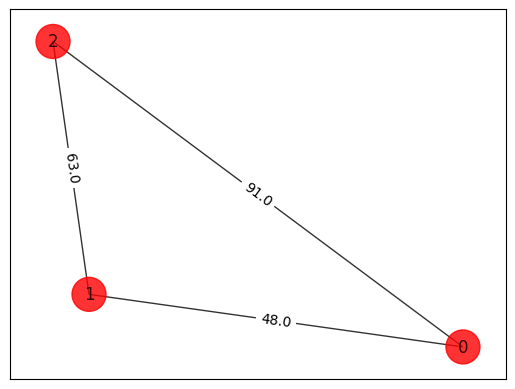

In [3]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

Classical Brute force approach

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


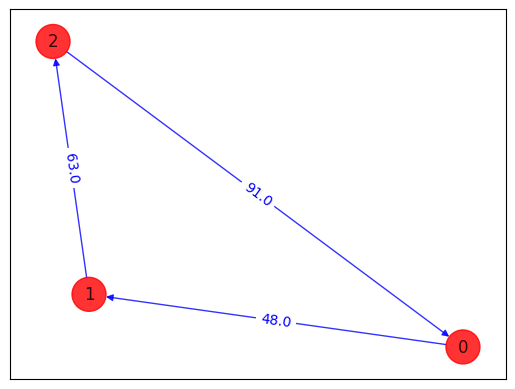

In [4]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)



draw_tsp_solution(tsp.graph, best_order, colors, pos)

#To Solve with Quantum Computer

Construct QUBO

In [5]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



QUBO to Hamiltonian

In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

Construct ansatz

In [9]:

ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
ry.decompose().decompose().draw()

┌─────────────┐          ┌─────────────┐                          »
q_0: ┤ R(θ[0],π/2) ├───────■──┤ R(θ[9],π/2) ├──────────────────────────»
     ├─────────────┤┌───┐┌─┴─┐└────┬───┬────┘     ┌──────────────┐┌───┐»
q_1: ┤ R(θ[1],π/2) ├┤ H ├┤ X ├─────┤ H ├───────■──┤ R(θ[10],π/2) ├┤ H ├»
     ├─────────────┤├───┤└───┘     └───┘     ┌─┴─┐└────┬───┬─────┘└───┘»
q_2: ┤ R(θ[2],π/2) ├┤ H ├────────────────────┤ X ├─────┤ H ├────────■──»
     ├─────────────┤├───┤                    └───┘     └───┘      ┌─┴─┐»
q_3: ┤ R(θ[3],π/2) ├┤ H ├─────────────────────────────────────────┤ X ├»
     ├─────────────┤├───┤                                         └───┘»
q_4: ┤ R(θ[4],π/2) ├┤ H ├──────────────────────────────────────────────»
     ├─────────────┤├───┤                                              »
q_5: ┤ R(θ[5],π/2) ├┤ H ├──────────────────────────────────────────────»
     ├─────────────┤├───┤                                              »
q_6: ┤ R(θ[6],π/2) ├┤ H ├──────────────────────────────────────────────»
     ├─────────────┤├───┤                                              »
q_7: ┤ R(θ[7],π/2) ├┤ H ├──────────────────────────────────────────────»
     ├─────────────┤├───┤                                              »
q_8: ┤ R(θ[8],π/2) ├┤ H ├──────────────────────────────────────────────»
     └─────────────┘└───┘                                              »
«                     ┌──────────────┐                                »
«q_0: ───────■────────┤ R(θ[18],π/2) ├────────────────────────────────»
«          ┌─┴─┐      └────┬───┬─────┘                ┌──────────────┐»
«q_1: ─────┤ X ├───────────┤ H ├─────────────■────────┤ R(θ[19],π/2) ├»
«     ┌────┴───┴─────┐     ├───┤           ┌─┴─┐      └────┬───┬─────┘»
«q_2: ┤ R(θ[11],π/2) ├─────┤ H ├───────────┤ X ├───────────┤ H ├──────»
«     └────┬───┬─────┘     └───┘      ┌────┴───┴─────┐     ├───┤      »
«q_3: ─────┤ H ├─────────────■────────┤ R(θ[12],π/2) ├─────┤ H ├──────»
«          └───┘           ┌─┴─┐      └────┬───┬─────┘     └───┘      »
«q_4: ─────────────────────┤ X ├───────────┤ H ├─────────────■────────»
«                          └───┘           └───┘           ┌─┴─┐      »
«q_5: ─────────────────────────────────────────────────────┤ X ├──────»
«                                                          └───┘      »
«q_6: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_7: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_8: ────────────────────────────────────────────────────────────────»
«                                                                     »
«                                     ┌──────────────┐                »
«q_0: ───────────────────────■────────┤ R(θ[27],π/2) ├────────────────»
«          ┌───┐           ┌─┴─┐      └────┬───┬─────┘                »
«q_1: ─────┤ H ├───────────┤ X ├───────────┤ H ├─────────────■────────»
«          └───┘      ┌────┴───┴─────┐     ├───┤           ┌─┴─┐      »
«q_2: ───────■────────┤ R(θ[20],π/2) ├─────┤ H ├───────────┤ X ├──────»
«          ┌─┴─┐      └────┬───┬─────┘     └───┘      ┌────┴───┴─────┐»
«q_3: ─────┤ X ├───────────┤ H ├─────────────■────────┤ R(θ[21],π/2) ├»
«     ┌────┴───┴─────┐     ├───┤           ┌─┴─┐      └────┬───┬─────┘»
«q_4: ┤ R(θ[13],π/2) ├─────┤ H ├───────────┤ X ├───────────┤ H ├──────»
«     └────┬───┬─────┘     └───┘      ┌────┴───┴─────┐     ├───┤      »
«q_5: ─────┤ H ├─────────────■────────┤ R(θ[14],π/2) ├─────┤ H ├──────»
«          └───┘           ┌─┴─┐      └────┬───┬─────┘     └───┘      »
«q_6: ─────────────────────┤ X ├───────────┤ H ├─────────────■────────»
«                          └───┘           └───┘           ┌─┴─┐      »
«q_7: ─────────────────────────────────────────────────────┤ X ├──────»
«                                                          └───┘      »
«q_8: ────────────────────

<ipython-input-10-5e09a132dde9>:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -7326.02469952184
time: 13.951514720916748
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


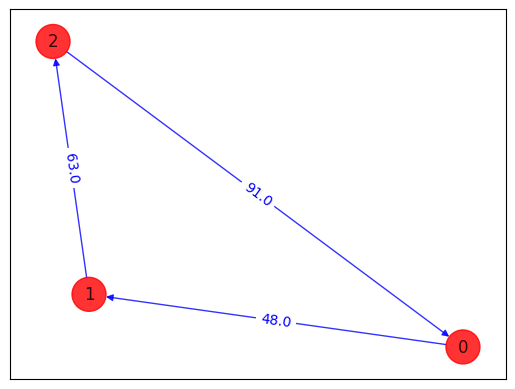

In [10]:
algorithm_globals.random_seed = 123
seed = 10598
optimizer = SPSA(maxiter=300)
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)  #here the mapping hamiltonion to qubit happens

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)